# Lesson 3 solutions 2: Higgs analysis with combinatorics

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import awkward as ak
import vector
from hist import Hist
vector.register_awkward()

In [2]:
events = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")

In [3]:
eplus = events.electron[events.electron.charge > 0]
eminus = events.electron[events.electron.charge < 0]

In [4]:
eplusplus = ak.combinations(eplus, 2)
eminusminus = ak.combinations(eminus, 2)
epairs_of_pairs = ak.cartesian([eplusplus, eminusminus])

In [5]:
interpretation1_z1 = epairs_of_pairs["0", "0"] + epairs_of_pairs["1", "0"]
interpretation1_z2 = epairs_of_pairs["0", "1"] + epairs_of_pairs["1", "1"]

interpretation2_z1 = epairs_of_pairs["0", "0"] + epairs_of_pairs["1", "1"]
interpretation2_z2 = epairs_of_pairs["0", "1"] + epairs_of_pairs["1", "0"]

<br><br><br>

## Solution to exercise 1

Separately for `interpretation1_*` and for `interpretation2_*`, use [ak.where](https://awkward-array.org/doc/main/reference/generated/ak.where.html) to distinguish the biggest Z mass from the smallest Z mass.

In [6]:
interpretation1_zsmall = ak.where(interpretation1_z1.mass < interpretation1_z2.mass, interpretation1_z1, interpretation1_z2)
interpretation1_zbig   = ak.where(interpretation1_z1.mass > interpretation1_z2.mass, interpretation1_z1, interpretation1_z2)

interpretation2_zsmall = ak.where(interpretation2_z1.mass < interpretation2_z2.mass, interpretation2_z1, interpretation2_z2)
interpretation2_zbig   = ak.where(interpretation2_z1.mass > interpretation2_z2.mass, interpretation2_z1, interpretation2_z2)

<br>

The masses of the lowest and highest e⁺e⁻ pair mass in interpretation 1 are:

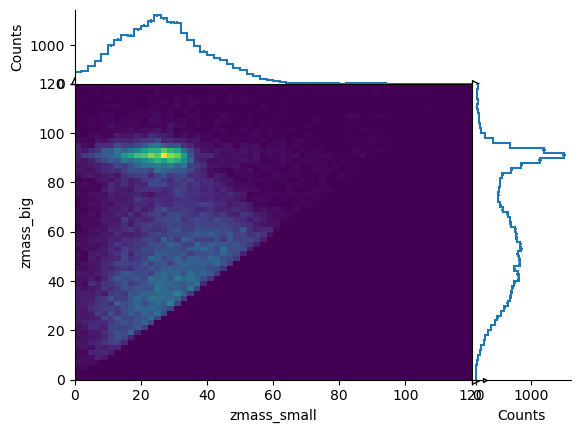

In [7]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(interpretation1_zsmall.mass),
    zmass_big=ak.flatten(interpretation1_zbig.mass),
).plot2d_full();

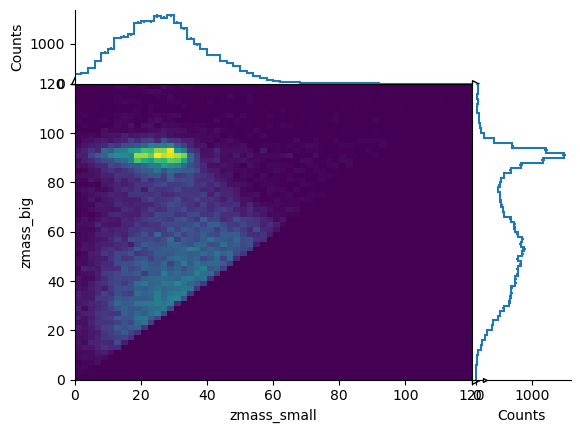

In [8]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(interpretation2_zsmall.mass),
    zmass_big=ak.flatten(interpretation2_zbig.mass),
).plot2d_full();

## Solution to exercise 2

If one interpretation has a highest e⁺e⁻ pair mass close to the on-shell Z mass and the other doesn't, then it is the most likely interpretation.

Apply the `(12 < zmass_small) & (zmass_small < 120) & (40 < zmass_big) & (zmass_big < 120)` quality cuts and plot the Higgs mass, separately for each interpretation.

In [9]:
interpretation1_quality = (
    (12 < interpretation1_zsmall.mass) & (interpretation1_zsmall.mass < 120) &
    (40 < interpretation1_zbig.mass) & (interpretation1_zbig.mass < 120)
)
interpretation2_quality = (
    (12 < interpretation2_zsmall.mass) & (interpretation2_zsmall.mass < 120) &
    (40 < interpretation2_zbig.mass) & (interpretation2_zbig.mass < 120)
)

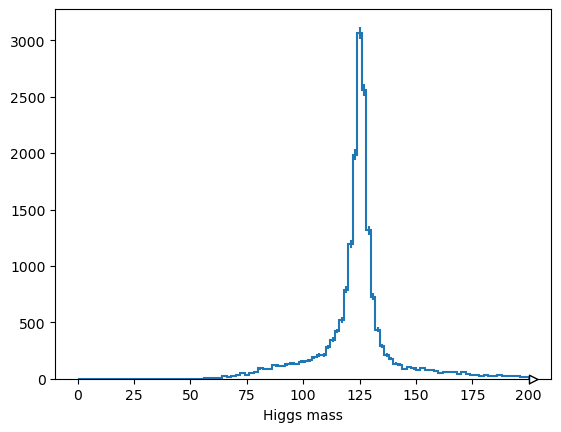

In [10]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((interpretation1_zsmall + interpretation1_zbig).mass[interpretation1_quality])
).plot();

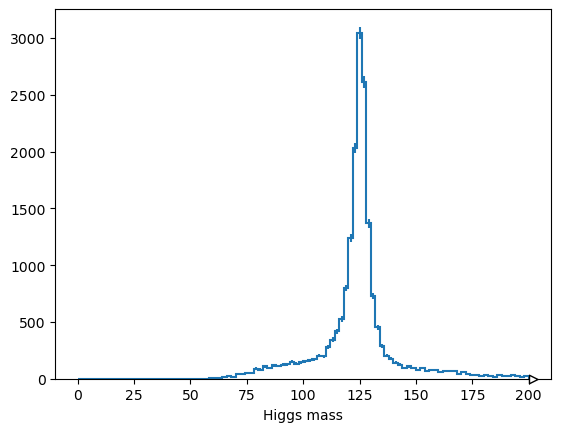

In [11]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((interpretation2_zsmall + interpretation2_zbig).mass[interpretation2_quality])
).plot();

## Solution to exercise 3

Just as we used [ak.where](https://awkward-array.org/doc/main/reference/generated/ak.where.html) to select between pair masses to find the lowest and highest per interpretation, use it to select between interpretations on a candidate-by-candidate basis.

In [12]:
from particle import Particle
from hepunits import GeV

onshell_mass = Particle.from_name("Z0").mass / GeV

In [13]:
interpretation1_is_best = abs(interpretation1_zbig.mass - onshell_mass) < abs(interpretation2_zbig.mass - onshell_mass)

In [14]:
best_interpretation_zbig = ak.where(interpretation1_is_best, interpretation1_zbig, interpretation2_zbig)
best_interpretation_zsmall = ak.where(interpretation1_is_best, interpretation1_zsmall, interpretation2_zsmall)

We are left with only one plot of the two Z bosons, in the best interpretation per candidate.

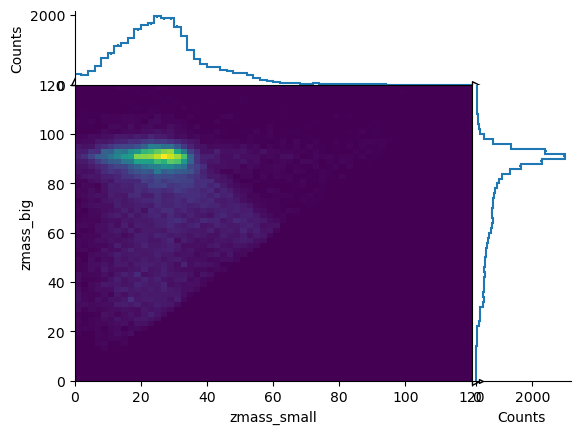

In [15]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(best_interpretation_zsmall.mass),
    zmass_big=ak.flatten(best_interpretation_zbig.mass),
).plot2d_full();

## Solution to exercise 4

Even though we have selected the best Z-to-electron-pair matching for each group of 4 electrons, we still have multiple (or zero) groups of 4 electrons per event.

In [16]:
best_interpretation_zbig

<MomentumArray4D [[], [{rho: 64.7, ...}], ..., [], []] type='299973 * var *...'>

Use the same criteria, namely that the Higgs candidate in which the highest-mass Z boson is nearly on shell, to find the best Higgs candidate per event. The [ak.min](https://awkward-array.org/doc/main/reference/generated/ak.min.html) function with `axis=-1` replaces lists with their minimum value and empty lists with `None`:

Use this technique to find the Higgs candidate in each event whose highest-mass Z boson has the closest to an on shell mass.

In [17]:
best_higgs_candidate_index = ak.argmin(abs(best_interpretation_zbig.mass - onshell_mass), axis=-1, keepdims=True)
best_higgs_candidate_index

<Array [[None], [0], [None], ..., [None], [None]] type='299973 * 1 * ?int64'>

In [18]:
best_higgs_zbig = best_interpretation_zbig[best_higgs_candidate_index][:, 0]
best_higgs_zsmall = best_interpretation_zsmall[best_higgs_candidate_index][:, 0]

best_higgs_zbig

<MomentumArray4D [None, {rho: 64.7, ...}, ..., None] type='299973 * ?Moment...'>

We are left with only one pair of Z bosons per event. ([ak.flatten](https://awkward-array.org/doc/main/reference/generated/ak.flatten.html) with `axis=0` removes the `None` values.)

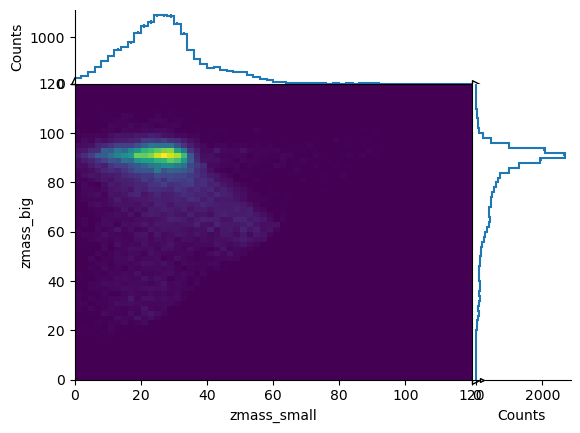

In [19]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(best_higgs_zsmall.mass, axis=0),
    zmass_big=ak.flatten(best_higgs_zbig.mass, axis=0),
).plot2d_full();

## Solution to exercise 5

Now apply the quality cut to the best interpretation to get a final Higgs mass plot. Ignore the `None` values; they pass through this cut.

In [20]:
best_interpretation_quality = (
    (12 < best_higgs_zsmall.mass) & (best_higgs_zsmall.mass < 120) &
    (40 < best_higgs_zbig.mass) & (best_higgs_zbig.mass < 120)
)

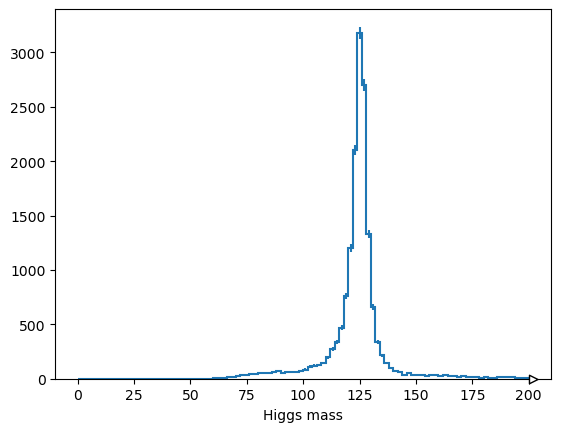

In [21]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((best_higgs_zsmall + best_higgs_zbig).mass[best_interpretation_quality], axis=0)
).plot();